# This script is built for implementation of FunkSVD

In [1]:
#!/usr/bin/python
# -*- coding: UTF-8 -*-
import random
import pandas as pd
import numpy as np
from collections import Counter

seed=15
random.seed(seed)
np.random.seed(seed=seed)

## Load Data

In [2]:
df = pd.read_csv("../data/movies/ratings_small.csv")
df = df.drop(["timestamp"], axis=1)
df = df[~df["rating"].isna()]
df.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


## Find Unique Users and Items. Then, Map to Pre-Defined IDs

In [3]:
uniqueUsers = df["userId"].unique()
uniqueItems = df["movieId"].unique()
userNum = len(uniqueUsers)
itemNum = len(uniqueItems)
print(f"Total {userNum} users and {itemNum} items")

# Build mapper for users and items
userMapper = dict(zip(uniqueUsers, range(userNum)))
itemMapper = dict(zip(uniqueItems, range(itemNum)))

df["userId"] = df["userId"].apply(lambda x: userMapper[x])
df["movieId"] = df["movieId"].apply(lambda x: itemMapper[x])

Total 671 users and 9066 items


## Split Data

In [4]:
validRatingMatrix = df.sample(frac=0.4, random_state=seed)
trainRatingMatrix = df.drop(index=validRatingMatrix.index)
print(f"Train dataframe has shape: {trainRatingMatrix.shape}")
print(f"Valid dataframe has shape: {validRatingMatrix.shape}")

trainRatingMatrix = trainRatingMatrix.to_numpy()
validRatingMatrix = validRatingMatrix.to_numpy()

Train dataframe has shape: (60002, 3)
Valid dataframe has shape: (40002, 3)


## Shuffle

In [5]:
indices = np.arange(trainRatingMatrix.shape[0])
np.random.shuffle(indices)

trainRatingMatrix = trainRatingMatrix[indices]

## Normalize

In [6]:
trainRatings = trainRatingMatrix[:, 2].astype(np.float32)
trainUserItems = trainRatingMatrix[:, :2].astype(np.int)

validRatings = validRatingMatrix[:, 2].astype(np.float32)
validUserItems = validRatingMatrix[:, :2].astype(np.int)

ratingMean, ratingStd = np.mean(trainRatings), np.std(trainRatings)
print(f"Ratings have mean={ratingMean:.3f}, std={ratingStd:.3f}")
trainRatings -= ratingMean
trainRatings /= ratingStd
validRatings -= ratingMean
validRatings /= ratingStd

Ratings have mean=3.538, std=1.060


## Hyperparameters

In [7]:
# Set for training
featureNum = 10
lr = 8e-3
decayRate = 0.9
epochs = 50
bestMse = 1e6

# Set for regularization
regRate = 1e-2

# Set for display
showInterval = 10

## Train and Validate

In [8]:
userMatrix = np.random.randn(userNum, featureNum).astype(np.float32)
itemMatrix = np.random.randn(itemNum, featureNum).astype(np.float32)
userBias = np.zeros(userNum).astype(np.float32)
itemBias = np.zeros(itemNum).astype(np.float32)
    
trainMses, trainMaes = [0] * epochs, [0] * epochs
validMses, validMaes = [0] * epochs, [0] * epochs
    
for epoch in range(epochs):
    if epoch > 0 and epoch % 20 == 0:
        lr *= decayRate
        print(f"***Set learning rate to {lr:.4f}")
        
    # ==========
    # Train
    # ==========
    for ((u, i), r) in zip(trainUserItems, trainRatings):  
        pred = np.dot(userMatrix[u, :], itemMatrix[i, :]) + userBias[u] + itemBias[i]
        diff = r - pred
        trainMses[epoch] += diff ** 2
        trainMaes[epoch] += abs(diff)

        for k in range(featureNum):
            userMatrix[u, k] += lr * (diff * itemMatrix[i, k] - regRate * userMatrix[u, k])
            itemMatrix[i, k] += lr * (diff * userMatrix[u, k] - regRate * itemMatrix[i, k])

        userBias[u] += lr * (diff - regRate * userBias[u])
        itemBias[i] += lr * (diff - regRate * itemBias[i])

    # ==========
    # Validation
    # ==========
    for ((u, i), r) in zip(validUserItems, validRatings):
        pred = np.dot(userMatrix[u, :], itemMatrix[i, :]) + userBias[u] + itemBias[i]
        diff = r - pred
        validMses[epoch] += diff ** 2
        validMaes[epoch] += abs(diff)

    trainMses[epoch] /= trainRatings.shape[0]
    validMses[epoch] /= trainRatings.shape[0]
    trainMaes[epoch] /= validRatings.shape[0]
    validMaes[epoch] /= validRatings.shape[0]

    # If model is the best, save matrices
    isbest = validMses[epoch] < bestMse
    bestMse = min(validMses[epoch], bestMse)
    if isbest:
        with open("funksvd/userMatrix.npy", "wb") as f:
            np.save(f, userMatrix)
        with open("funksvd/itemMatrix.npy", "wb") as f:
            np.save(f, itemMatrix)
        print(f"Save the best model at epoch={epoch+1}, mse={validMses[epoch]:.3f}, mae={validMaes[epoch]:.3f}")
        
    # Display stats
    if (epoch+1) % showInterval == 0:
        print(f"\n{'-' * 50}")
        print(f"(Epoch {epoch+1})")
        print(f"MSE: train:{trainMses[epoch]:.3f}, valid:{validMses[epoch]:.3f}")
        print(f"MAE: train:{trainMaes[epoch]:.3f}, valid:{validMaes[epoch]:.3f}")
        print(f"{'-' * 50}\n")

Save the best model at epoch=1, mse=1.595, mae=1.121
Save the best model at epoch=2, mse=1.139, mae=0.947
Save the best model at epoch=3, mse=0.969, mae=0.876
Save the best model at epoch=4, mse=0.880, mae=0.838
Save the best model at epoch=5, mse=0.827, mae=0.814
Save the best model at epoch=6, mse=0.791, mae=0.798
Save the best model at epoch=7, mse=0.766, mae=0.787
Save the best model at epoch=8, mse=0.747, mae=0.778
Save the best model at epoch=9, mse=0.733, mae=0.771
Save the best model at epoch=10, mse=0.722, mae=0.766

--------------------------------------------------
(Epoch 10)
MSE: train:0.648, valid:0.722
MAE: train:0.937, valid:0.766
--------------------------------------------------

Save the best model at epoch=11, mse=0.713, mae=0.762
Save the best model at epoch=12, mse=0.706, mae=0.759
Save the best model at epoch=13, mse=0.700, mae=0.756
Save the best model at epoch=14, mse=0.696, mae=0.753
Save the best model at epoch=15, mse=0.692, mae=0.752
Save the best model at e

## Plot MSE and MAE

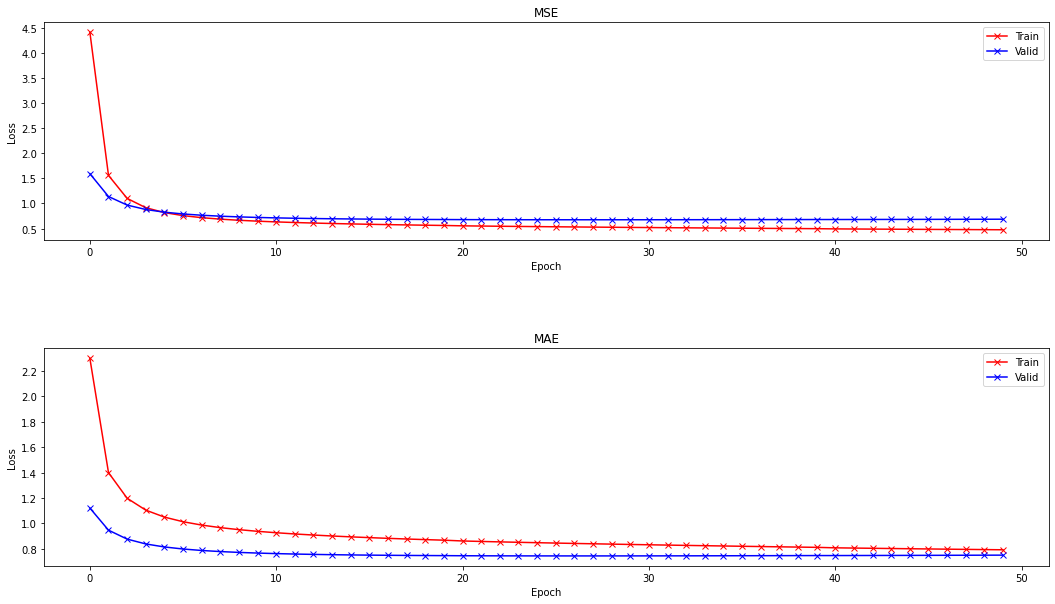

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18,10))
fig.subplots_adjust(hspace=0.5)

ax1.set_title("MSE")
ax1.plot(range(epochs), trainMses, "x-", color="r", label="Train")
ax1.plot(range(epochs), validMses, "x-", color="b", label="Valid")
ax1.set(xlabel="Epoch", ylabel="Loss")
ax1.legend(loc="upper right")

ax2.set_title("MAE")
ax2.plot(range(epochs), trainMaes, "x-", color="r", label="Train")
ax2.plot(range(epochs), validMaes, "x-", color="b", label="Valid")
ax2.set(xlabel="Epoch", ylabel="Loss")
ax2.legend(loc="upper right")

plt.savefig("funksvd/loss.png")
plt.show()